### Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import feather
from os import listdir
from os.path import join, isfile
sns.set(style="whitegrid")
pd.options.mode.chained_assignment = None 

--------------------------------------

### Load correlation matrices

In [2]:
#fileList = ['corrMatsNormExp/' + f for f in listdir('corrMatsNormExp/') if isfile(join('corrMatsNormExp/', f))]
fileList = ['corrMats/' + f for f in listdir('corrMats/') if isfile(join('corrMats/', f))]
fileList

['corrMats/corrMat0.feather',
 'corrMats/corrMat1.feather',
 'corrMats/corrMat2.feather',
 'corrMats/corrMat3.feather',
 'corrMats/corrMat4.feather',
 'corrMats/corrMat5.feather',
 'corrMats/corrMat6.feather',
 'corrMats/corrMat7.feather',
 'corrMats/corrMat8.feather',
 'corrMats/corrMat9.feather']

--------------------------------------

### Compute the max-abs-mean correlation

Functions used to compute the correlation between two methods, calculating 2 ways:
1. method1 as test, method2 as benchmark
2. method2 as test, method1 as benchmark

In [3]:
def compute_correlation(absMat, feat_i):
    
    # for each feature in the method, take the maximum correlation
    maxList = []
    
    for feat in absMat[feat_i].unique():
        
        maxList.append(absMat[absMat[feat_i] == feat]['corr'].max())
    
    # last step: take the mean of all the maximum values
    return (sum(maxList) / len(maxList))


def correlation_between_methods(corrMat, resDF):
    
    # drop all rows with NaN value
    absMat = corrMat.dropna()
    absMat['corr'] = absMat['corr'].abs()
    
    method1 = corrMat['method1'].unique()[0]
    method2 = corrMat['method2'].unique()[0]
    
    corr1 = compute_correlation(absMat, 'feat1')
    corr2 = compute_correlation(absMat, 'feat2')
    
    newRow1 = {'test': method1, 'benchmark': method2, 'corr': corr1}
    newRow2 = {'test': method2, 'benchmark': method1, 'corr': corr2}
    
    resDF = pd.concat([resDF, pd.DataFrame.from_dict([newRow1]), pd.DataFrame.from_dict([newRow2])], ignore_index=True)
    
    return resDF

In [4]:
mat = pd.DataFrame(columns=['test', 'benchmark', 'corr'])
corrMatList = []

for file in fileList:
    
    df = feather.read_dataframe(file)
    corrMatList.append(df)
    mat = correlation_between_methods(df, mat)

Store the correlation values in an orderer (smallest to biggest feature set).

In [5]:
methodsRev = ['tsfresh', 'tsfel', 'tsfeatures', 'kats', 'catch22']
methods    = ['catch22', 'kats', 'tsfeatures', 'tsfel', 'tsfresh']

results = []

for benchmark in methodsRev:
    
    correlations = pd.pivot_table(mat[mat['benchmark'] == benchmark], columns=['test'])
    correlations[benchmark] = 1
    
    # to store the values
    arr = np.ones(len(correlations.columns))
    
    for col in correlations:
        ind = methods.index(col)
        
        arr[ind] = correlations[col]
    
    results.append(arr)
    
res = pd.DataFrame(results, methodsRev, methods)

/tmp/ipykernel_589/1103137380.py:8: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  correlations = pd.pivot_table(mat[mat['benchmark'] == benchmark], columns=['test'])
/tmp/ipykernel_589/1103137380.py:8: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  correlations = pd.pivot_table(mat[mat['benchmark'] == benchmark], columns=['test'])
/tmp/ipykernel_589/1103137380.py:8: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  correlations = pd.pivot_table(mat[mat['benchmark'] == benchmark], columns=['test'])
/tmp/ipykernel_589/1103137380.py:8: Futu

--------------------------------------

### Plot heatmap

Reconstructed correlation matrix:

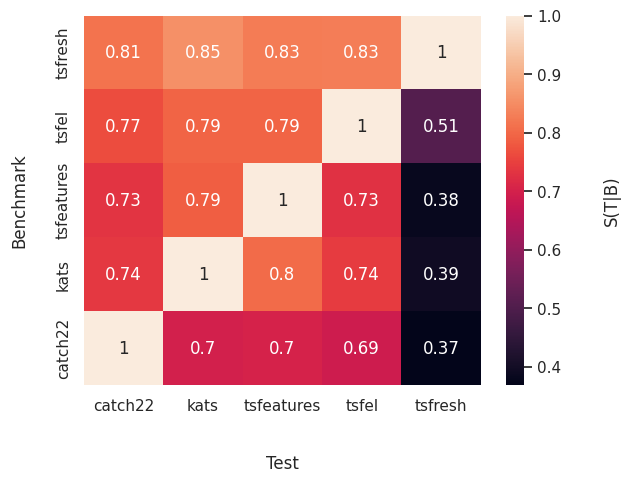

In [9]:
correlationMatrix = sns.heatmap(res, annot=True)
#correlationMatrix.set(xlabel='Test', ylabel='Benchmark')

ax = correlationMatrix

ax.set_ylabel('Benchmark', labelpad=20)
ax.set_xlabel('Test', labelpad=30)
ax.collections[0].colorbar.set_label("S(T|B)", labelpad=30)

fig = correlationMatrix.get_figure()
fig.savefig('outputs/correlationMatrix.pdf', bbox_inches='tight') 